## Test notebook

## Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

# Import all the components from your refactored code
from utils.data_handler import load_data, split_data
from utils.models import TreeFarmsWrapper, RandomForestWrapper, BNNWrapper, GaussianProcessWrapper
from utils.selectors import PassiveSelector, QBCSelector, BALDSelector
from utils.learning_procedure import SimulationConfig, run_learning_procedure, SimulationResult

ModuleNotFoundError: No module named 'treefarms.treefarms'

## Experiment Configurations

In [ ]:
# --- Main Configuration ---
DATASET_NAME = "Iris"
MODEL_NAME = "RandomForest"
SELECTOR_NAME = "Passive"
SEED = 123

# --- Model & Selector Specific Parameters ---
# Add any parameters your chosen model or selector needs
ADDITIONAL_CONFIG = {
    "n_estimators": 100,
    "use_unique_trees": True, # For QBCSelector
    "rashomon_threshold": 0.03, # For TreeFarmsWrapper
    "regularization": 0.01 # For TreeFarmsWrapper
}

## Set up and run

In [ ]:
# Registries to map names to classes
MODEL_REGISTRY = {
    "TreeFarms": TreeFarmsWrapper,
    "RandomForest": RandomForestWrapper,
    "GPC": GaussianProcessWrapper,
    "BNN": BNNWrapper,
}
SELECTOR_REGISTRY = {
    "Passive": PassiveSelector,
    "QBC": QBCSelector,
    "BALD": BALDSelector,
}

# 1. Load and split the data
# The path is relative to the notebook's location in src/notebooks/
df = load_data(DATASET_NAME, base_path=Path("../data/processed"))
df_train, df_test, df_candidate = split_data(
    df,
    test_proportion=0.2,
    candidate_proportion_of_remainder=0.8
)

# 2. Instantiate the model and selector
model_class = MODEL_REGISTRY[MODEL_NAME]
selector_class = SELECTOR_REGISTRY[SELECTOR_NAME]

config_params = {"random_state": SEED, **ADDITIONAL_CONFIG}
model = model_class(**config_params)
selector = selector_class(**config_params)

# 3. Create the simulation configuration object
sim_config = SimulationConfig(
    model=model,
    selector=selector,
    df_train=df_train,
    df_test=df_test,
    df_candidate=df_candidate,
)

# 4. Run the learning procedure!
print("--- Starting Experiment ---")
result = run_learning_procedure(sim_config)
print("--- Experiment Complete ---")

# 5. Save the results
output_dir = Path(f"../results/{DATASET_NAME}")
output_dir.mkdir(parents=True, exist_ok=True)
filename = f"{MODEL_NAME}_{SELECTOR_NAME}_seed{SEED}_notebook_run.pkl"
output_path = output_dir / filename

with open(output_path, "wb") as f:
    pickle.dump(result, f)

print(f"Results saved to: {output_path}")

## Plot results

NameError: name 'result' is not defined

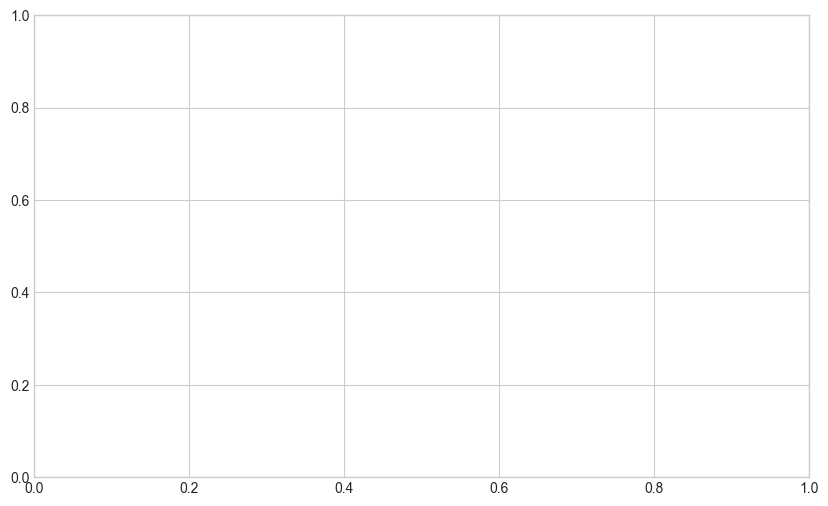

In [3]:
# Create a plot of accuracy over the simulation
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

iterations = range(1, len(result.accuracy_history) + 1)
ax.plot(iterations, result.accuracy_history, marker='o', linestyle='-', label='Model Accuracy')

ax.set_title(f"Accuracy vs. Iteration ({DATASET_NAME} | {MODEL_NAME} | {SELECTOR_NAME})", fontsize=16)
ax.set_xlabel("Number of Labeled Samples Added", fontsize=12)
ax.set_ylabel("Test Set Accuracy", fontsize=12)
ax.legend()
ax.grid(True)

plt.show()